In [77]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def dropout_layer(X, dropout):
  assert 0 <= dropout <= 1
  if dropout == 1: return torch.zeros_like(X)
  mask = (torch.rand(X.shape) > dropout).float()
  return (X * mask) / (1.0 - dropout)

In [3]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  0.,  6.,  0., 10.,  0.,  0.],
        [ 0.,  0., 20.,  0., 24., 26.,  0.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [6]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

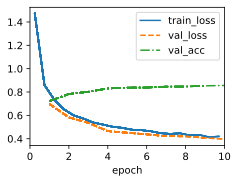

In [7]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [8]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

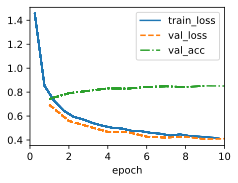

In [9]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

### Exercises

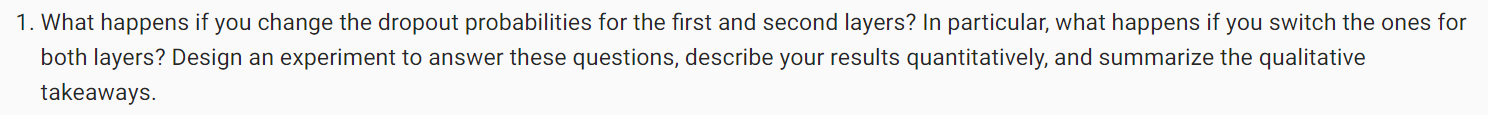

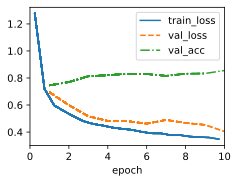

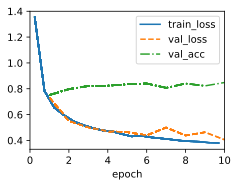

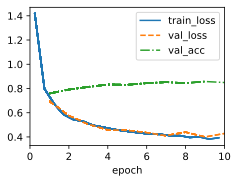

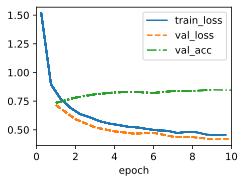

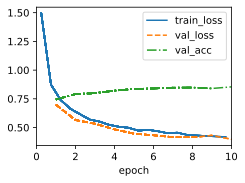

In [12]:
dropouts_vals = [
  (0, 0), (0, 0.5), (0.5, 0), (0.7, 0.3), (0.3, 0.7)
]

for dropout_1, dropout_2 in dropouts_vals:
  hparams = {
    'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
    'dropout_1':dropout_1, 'dropout_2': dropout_2, 'lr':0.1
  }
  model = DropoutMLPScratch(**hparams)
  data = d2l.FashionMNIST(batch_size=256)
  trainer = d2l.Trainer(max_epochs=10)
  trainer.fit(model, data)

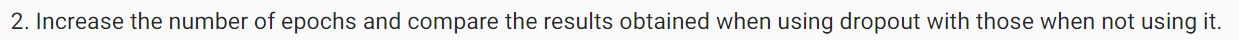

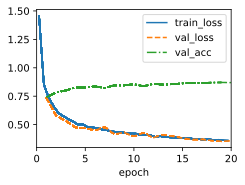

In [13]:
hparams = {
    'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
    'dropout_1':0.5, 'dropout_2': 0.5, 'lr':0.1
  }
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

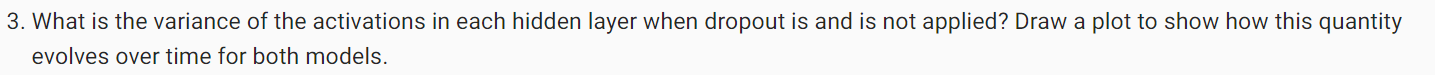

In [57]:
def activation_variance(X):
  mean = X.mean(dim=0, keepdim=True)
  return torch.mean((X - mean)**2, dim=0, keepdim=True)

In [70]:
class DropoutMLPScratchV2(d2l.Classifier):
  def __init__(self, num_outputs, num_hiddens, lr, dropouts):
    super().__init__()
    self.save_hyperparameters()
    self.activations_indices = []
      
    layers = []
    layers.append(nn.Flatten())
    
    for i in range(len(self.num_hiddens)):
      layers.append(nn.LazyLinear(self.num_hiddens[i]))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(self.dropouts[i]))
      self.activations_indices.append(3 + i * 3)
      
    layers.append(nn.LazyLinear(num_outputs))
    
    self.net = nn.Sequential(*layers)
    
  def training_step(self, batch):
    
    for act_i in self.activations_indices:
      out = self.net[:act_i + 1](*batch[:-1])
      out_var = activation_variance(out)
      self.plot(f'variance: layer {act_i}', torch.mean(out_var), train=True)
      
    y = batch[-1]
    y_hat = self(*batch[:-1])
    l = self.loss(y_hat, y)
    
    self.plot('loss', l, train=True)
    return l

  def validation_step(self, batch):
    for act_i in self.activations_indices:
      out = self.net[:act_i + 1](*batch[:-1])
      out_var = activation_variance(out)
      self.plot(f'variance: layer {act_i}', torch.mean(out_var), train=False)
      
    y = batch[-1]
    y_hat = self(*batch[:-1])
    l = self.loss(y_hat, y)
    
    self.plot('loss', l, train=False)

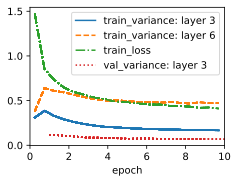

In [71]:
hparams = {
    'num_outputs':10,
    'lr':0.1,
    'num_hiddens': [256, 256],
    'dropouts': [0.5, 0.5]
  }
model = DropoutMLPScratchV2(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

Observation 1: Variance when dropout is not applied (val) is small and stable. val_variance: layer 3 is the lowest and most stable line. Because dropout is turned off during validation, the signal is "clean" and consistent across batches.

Observation 2: Variance when dropout is applied (train) is bigger due to randomness. Dropout introduces noise by randomly setting neurons to zero. This "switching" effect increases the variance of the activations across the batch because different neurons are contributing to the signal in different samples.

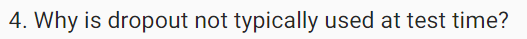

The reason why we not using the dropout in a test time is simple - we just do not need it. Since dropout is a regularization tecnique that is used for preventing model from being too complex - we do not need it in a test time. But the problem is the decreasing of power by `p(dropout)`. To solve this issue, we just divide our zeroed signal `X` by `1 - p(dropout)`

In short:
- Training Time: The goal is to prevent overfitting. We use dropout to force the network to learn redundant,   robust features so it doesn't rely on any single neuron (breaking symmetry and preventing "co-adaptation").
- Test Time: The goal is to get the best possible prediction. We want to use the entire capacity of the network that we just spent hours training. Dropping neurons at test time would just add random noise to our predictions and make the model less accurate.

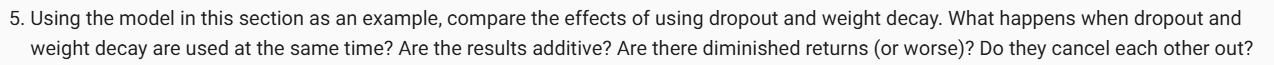

In [ ]:
class DropoutMLPScratchV2(d2l.Classifier):
  def __init__(self, num_outputs, num_hiddens, lr, dropouts, wd):
    super().__init__()
    self.save_hyperparameters()
      
    layers = []
    layers.append(nn.Flatten())
    
    for i in range(len(self.num_hiddens)):
      layers.append(nn.LazyLinear(self.num_hiddens[i]))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(self.dropouts[i]))
      
    layers.append(nn.LazyLinear(num_outputs))
    
    self.net = nn.Sequential(*layers)
    
  def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.wd)

KeyboardInterrupt: 

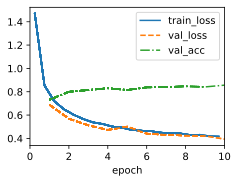

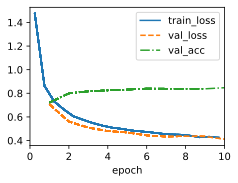

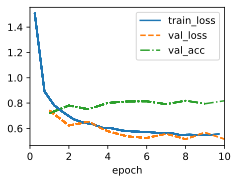

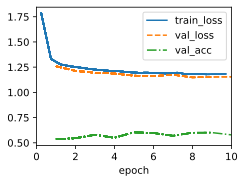

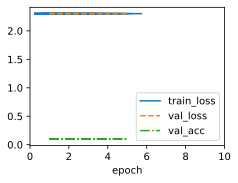

In [ ]:
hparams = {
    'num_outputs':10,
    'lr':0.1,
    'num_hiddens': [256, 256],
    'dropouts': [0.5, 0.5],
  }

for wd in [0, 0.001, 0.01, 0.1, 1]:
  model = DropoutMLPScratchV2(**hparams, wd=wd)
  data = d2l.FashionMNIST(batch_size=256)
  trainer = d2l.Trainer(max_epochs=10)
  trainer.fit(model, data)